In [1]:
from sys import stdout
import sys

import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime

In [2]:
# !git clone https://github.com/stefanknegt/Probabilistic-Unet-Pytorch.git

In [3]:
# !git clone https://github.com/thilowrona/seismic_deep_learning

In [4]:
sys.path.append('Probabilistic-Unet-Pytorch/')
sys.path.append('seismic_deep_learning/tutorial-10/')

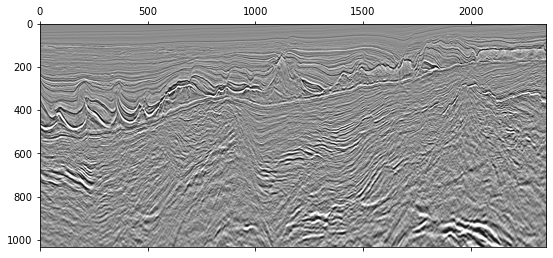

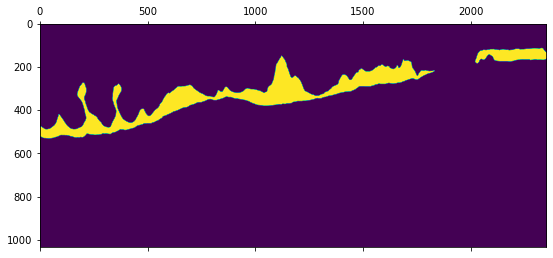

In [5]:
data = mpimg.imread('seismic_deep_learning/tutorial-1/seismic.tif')
data = data[:,:,:1]/255

mask = mpimg.imread('seismic_deep_learning/tutorial-1/mask.tif').copy()
mask = (mask-mask.min())/(mask.max()-mask.min())

plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.show()
plt.matshow(mask, interpolation='spline16', aspect=1)
plt.show()

In [6]:
patch_num  = 10000                               # Number of patches
patch_size = 128                                 # Patch size
val_split  = 0.2                                 # Validation split
batch_size = 32


def extract_patches(data, mask, patch_num, patch_size):

  X = np.empty((patch_num, patch_size, patch_size,1))
  Y = np.empty((patch_num, patch_size, patch_size,1))

  (t_max, x_max, _) = data.shape

  for n in range(patch_num):
      
      # Select random point in data (not too close to edge)   
      x_n = random.randint(patch_size//2,x_max-patch_size//2)
      t_n = random.randint(patch_size//2,t_max-patch_size//2)
      
      # Extract data and mask patch around point   
      X[n,:,:,0] = data[t_n-patch_size//2:t_n+patch_size//2,x_n-patch_size//2:x_n+patch_size//2,0]
      Y[n,:,:,0] = mask[t_n-patch_size//2:t_n+patch_size//2,x_n-patch_size//2:x_n+patch_size//2]


  return X, Y


X_train, Y_train = extract_patches(data[:,:1500], mask[:,:1500], int(patch_num*(1-val_split)), patch_size)
X_val,   Y_val   = extract_patches(data[:,1500:], mask[:,1500:], int(patch_num*(1-val_split)), patch_size)

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [8]:
X_train = torch.Tensor(X_train).permute(0, 3, 1, 2)
Y_train = torch.Tensor(Y_train).permute(0, 3, 1, 2)
X_val = torch.Tensor(X_val).permute(0, 3, 1, 2)
Y_val = torch.Tensor(Y_val).permute(0, 3, 1, 2)

train_tensors = torch.cat((X_train, Y_train), 1)
val_tensors = torch.cat((X_val, Y_val), 1)

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
from probabilistic_unet import ProbabilisticUnet
from utils import l2_regularisation
from tqdm.auto import tqdm, trange

In [49]:
class Logger(object):
    def __init__(self):
        self.metrics = ['elbo', 'reconstruction_loss', 'mse_loss', 'std', 'kl diveregence', 'reg_loss']
        self.lists = [[], [], [], [], [], []]
        self.steps = []
    def step(self, global_step, *args):
        for i, value in enumerate(args):
            self.lists[i].append(value.item())
        self.steps.append(global_step)

In [63]:
net = ProbabilisticUnet(input_channels=1, 
                        num_classes=1, 
                        num_filters=[4,8,16,32], 
                        latent_dim=4, 
                        no_convs_fcomb=2, 
                        beta=1.0)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5, weight_decay=0)
epochs = 10
global_step = 0
save_every_steps = 5
summary = SummaryWriter("tensorboard" + datetime.now().strftime('%d%m%y%H%M:%S'))
nsamples = 64
mse_criteria = nn.MSELoss()
logger = Logger()
for epoch in trange(epochs, desc = 'epochs'):
    for step in trange(len(train_loader), desc='batches', leave=False):
        patch, mask = next(iter(train_loader))
        patch = patch.to(device)
        mask = mask.to(device)
        net.forward(patch, mask, training=True)
        elbo = net.elbo(mask)
        reg_loss = l2_regularisation(net.posterior) + l2_regularisation(net.prior) + l2_regularisation(net.fcomb.layers)
        loss = -elbo + 1e-5 * reg_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if global_step % save_every_steps == 0:
            mean_pred = torch.zeros_like(mask)
            mean_sq_pred = torch.zeros_like(mask)
            for _ in range(nsamples):
                mean_pred += net.sample()
                mean_sq_pred += mean_pred**2
            mean_pred /= nsamples
            mean_sq_pred /= nsamples
            var_pred = (mean_sq_pred - mean_pred**2)
            mse = mse_criteria(mask, mean_pred)
            std = var_pred.mean()**0.5
            logger.step(global_step, elbo, net.reconstruction_loss, mse, std, net.kl, reg_loss)
            summary.add_scalar("elbo",elbo,global_step)
            summary.add_scalar("reconstruction_loss",net.reconstruction_loss,global_step)
            summary.add_scalar("mse_loss",mse,global_step)
            summary.add_scalar("std",std,global_step)
            summary.add_scalar("kl diveregence",net.kl,global_step)
            summary.add_scalar("reg_loss",reg_loss,global_step)
        global_step += 1

epochs:   0%|          | 0/10 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

batches:   0%|          | 0/250 [00:00<?, ?it/s]

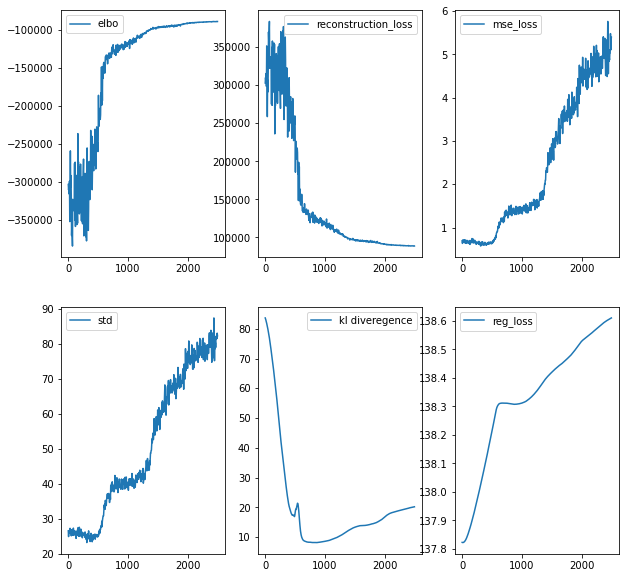

In [64]:
ncols = 3
nrows = len(logger.metrics) // ncols
fig, axs = plt.subplots(figsize = (10, 10), ncols = ncols, nrows = nrows)
for i, name in enumerate(logger.metrics):
    axs.flatten()[i].plot(logger.steps, logger.lists[i], label = name)
    axs.flatten()[i].legend()

In [73]:
patch, mask = next(iter(train_loader))
net.forward(patch.to(device), None, training=False)

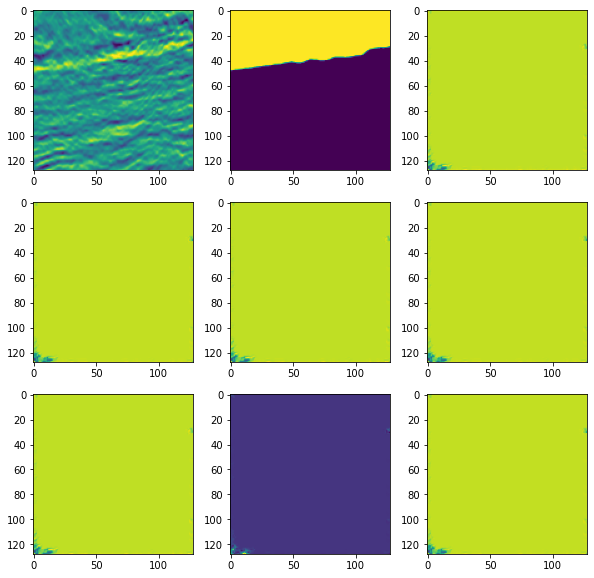

In [75]:
i = np.random.randint(batch_size)

nsamples = 7
ncols = 3
nrows = (nsamples+2) // ncols
fig, axs = plt.subplots(figsize = (10, 10), ncols = ncols, nrows = nrows)
axs.flatten()[0].imshow(patch[i,0])
axs.flatten()[1].imshow(mask[i,0])
for j in range(nsamples):
    pred_mask = net.sample().detach().cpu()
    axs.flatten()[j+2].imshow(pred_mask[i,0])